In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns 
import xgboost as xgb
from sklearn.metrics import  roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')
from tqdm import tqdm
from lightgbm import LGBMClassifier

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving train[1].csv to train[1].csv


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving test[1].csv to test[1].csv


In [ ]:
pd.set_option('display.max_columns', None)

In [ ]:
X = pd.read_csv('train[1].csv')
test = pd.read_csv('test[1].csv')
test_id = test['id']
test.drop('id', axis=1, inplace=True)
y = X['target']
train = X.drop(['id','target'], axis=1)

In [ ]:
train.head()

,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,ps_ind_09_bin,ps_ind_10_bin,ps_ind_11_bin,ps_ind_12_bin,ps_ind_13_bin,ps_ind_14,ps_ind_15,ps_ind_16_bin,ps_ind_17_bin,ps_ind_18_bin,ps_reg_01,ps_reg_02,ps_reg_03,ps_car_01_cat,ps_car_02_cat,ps_car_03_cat,ps_car_04_cat,ps_car_05_cat,ps_car_06_cat,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15,ps_calc_01,ps_calc_02,ps_calc_03,ps_calc_04,ps_calc_05,ps_calc_06,ps_calc_07,ps_calc_08,ps_calc_09,ps_calc_10,ps_calc_11,ps_calc_12,ps_calc_13,ps_calc_14,ps_calc_15_bin,ps_calc_16_bin,ps_calc_17_bin,ps_calc_18_bin,ps_calc_19_bin,ps_calc_20_bin
0,2,2,5,1,0,0,1,0,0,0,0,0,0,0,11,0,1,0,0.7,0.2,0.718070,10,1,-1,0,1,4,1,0,0,1,12,2,0.400000,0.883679,0.370810,3.605551,0.6,0.5,0.2,3,1,10,1,10,1,5,9,1,5,8,0,1,1,0,0,1
1,1,1,7,0,0,0,0,1,0,0,0,0,0,0,3,0,0,1,0.8,0.4,0.766078,11,1,-1,0,-1,11,1,1,2,1,19,3,0.316228,0.618817,0.388716,2.449490,0.3,0.1,0.3,2,1,9,5,8,1,7,3,1,1,9,0,1,1,0,1,0
2,5,4,9,1,0,0,0,1,0,0,0,0,0,0,12,1,0,0,0.0,0.0,-1.000000,7,1,-1,0,-1,14,1,1,2,1,60,1,0.316228,0.641586,0.347275,3.316625,0.5,0.7,0.1,2,2,9,1,8,2,7,4,2,7,7,0,1,1,0,1,0
3,0,1,2,0,0,1,0,0,0,0,0,0,0,0,8,1,0,0,0.9,0.2,0.580948,7,1,0,0,1,11,1,1,3,1,104,1,0.374166,0.542949,0.294958,2.000000,0.6,0.9,0.1,2,4,7,1,8,4,2,2,2,4,9,0,0,0,0,0,0
4,0,2,0,1,0,1,0,0,0,0,0,0,0,0,9,1,0,0,0.7,0.6,0.840759,11,1,-1,0,-1,14,1,1,2,1,82,3,0.316070,0.565832,0.365103,2.000000,0.4,0.6,0.0,2,2,6,3,10,2,12,3,1,1,3,0,0,0,1,1,0


In [ ]:
train.shape, test.shape 

((595212, 57), (892816, 57))

In [ ]:
# Code for calculating Normalized gini coefficient
def gini(actual, pred, cmpcol = 0, sortcol = 1):  
    assert( len(actual) == len(pred) )  
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)  
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]  
    totalLosses = all[:,0].sum()  
    giniSum = all[:,0].cumsum().sum() / totalLosses  
  
    giniSum -= (len(actual) + 1) / 2  
    return giniSum / len(actual)  
  
def gini_normalized(a, p):  
    '''Function to calculate the normalized gini coefficient'''
    return gini(a, p) / gini(a, a) 

In [ ]:
def missing_values(data):
    '''Function to find the percentage of missing values in each column of a DataFrame passed'''
    for i in data.columns.values:
        count =  data[data[i] == -1].shape[0]
        print("Missing Values in '{}' : {:.4f} %".format(i, (count/data.shape[0])*100))

In [ ]:
def filling_missing_values(data):
    '''A function to fill in the missing values of categorical features'''
    for i in tqdm(data.columns.values):
        if data[data[i] == -1].shape[0] > 0:
            if i == 'ps_car_03_cat' or i == 'ps_car_05_cat':
                continue
            elif i == 'ps_ind_05_cat' or i == 'ps_car_07_cat':
                lst = data[i].apply(lambda x:data[i].mode() if x == -1 else x)
                data[i] = pd.Series(lst)
            else:
                lst = data[i].apply(lambda x:data[i].mean() if x == -1 else x)
                data[i] = pd.Series(lst)
        else:
            continue
    return data

In [ ]:
def one_hot_encoding(train, test, cat_features):
    '''Function to one-hot-encode categorical features'''
    temp = pd.concat([train, test])
    temp = pd.get_dummies(temp, columns = cat_features)
    train = temp.iloc[:train.shape[0],:]
    test = temp.iloc[train.shape[0]:, :]
    return train, test

In [ ]:
def target_encoding(train, test, target, cat_features):
    '''Function to target encode categorical data'''
    prior = target.mean()
   # features = train.columns.values
    train['target'] = target
    
    def smooth(x, mean, count, prior, smoothing=1, min_samples_leaf = 1):
        smoothing = 1 / (1 + np.exp(-(count - min_samples_leaf) / smoothing))
        return (prior * (1 - smoothing) + mean * smoothing)
   
    for i in cat_features:
        
        v = train.groupby(i)['target'].agg(['mean','count'])
        
        train[i] = train[i].apply(lambda x : smooth(x, v['mean'][x], v['count'][x], prior))
        test[i] = test[i].apply(lambda x : smooth(x, v['mean'][x], v['count'][x], prior)) 
            
    train.drop(['target'], axis=1, inplace = True)
        
    return train, test

In [ ]:
def label_encoding(train, test, cat_features):
    '''Function to label encode categorical variables'''
    for i in cat_features:
        le = LabelEncoder()
        le.fit(train[i])
        train[i] = le.transform(train[i])
        test[i] = le.transform(test[i])
    return train, test

In [ ]:
def freq_encoding(train, test, cat_features):
    '''Function to frequency encode categorical variables'''
    for i in cat_features:
        vc = train[i].value_counts()
        train[i] = train[i].apply(lambda x: vc[x])
        test[i] = test[i].apply(lambda x: vc[x])
    return train, test

In [ ]:
imbalance = y.value_counts()
print("Percent of Insurance Claimed(Class 1) : ", (imbalance[1]/train.shape[0])*100)
print("Percent of Insurance Not Claimed(Class 0) : ", (imbalance[0]/train.shape[0])*100)

Percent of Insurance Claimed(Class 1) :  3.6447517859182947
Percent of Insurance Not Claimed(Class 0) :  96.3552482140817


In [ ]:
all_features = train.columns.values
cat_features = []
for i in train.columns.values:
    if i.endswith('cat'):
        cat_features.append(i)
    else:
        continue

bin_features = []
for i in train.columns.values:
    if i.endswith('bin'):
        bin_features.append(i)
    else:
        continue

calc_features = []
for i in train.columns.values:
    if i.startswith('ps_calc'):
        calc_features.append(i)
    else:
        continue

calc_bin_features = []
for i in calc_features:
    if i.endswith('bin'):
        calc_bin_features.append(i)
    else:
        continue

calc_num_features = list(set(calc_features) - set(calc_bin_features))
num_features_with_calc = list((set(train.columns.values) - set(cat_features)) - set(bin_features))
num_features_wo_calc = list(set(num_features_with_calc) - set(calc_features))

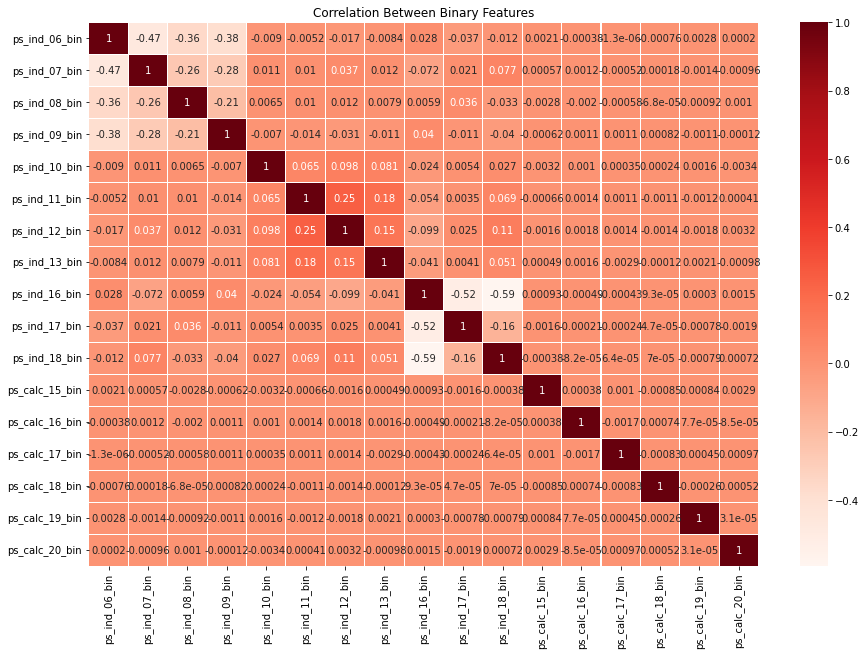

In [ ]:
plt.figure(figsize=(15,10))
plt.title("Correlation Between Binary Features")
sns.heatmap(train[bin_features].corr(), cmap='Reds', annot = True, linewidths=0.01)

In [ ]:
missing_values(train[bin_features])

Missing Values in 'ps_ind_06_bin' : 0.0000 %
Missing Values in 'ps_ind_07_bin' : 0.0000 %
Missing Values in 'ps_ind_08_bin' : 0.0000 %
Missing Values in 'ps_ind_09_bin' : 0.0000 %
Missing Values in 'ps_ind_10_bin' : 0.0000 %
Missing Values in 'ps_ind_11_bin' : 0.0000 %
Missing Values in 'ps_ind_12_bin' : 0.0000 %
Missing Values in 'ps_ind_13_bin' : 0.0000 %
Missing Values in 'ps_ind_16_bin' : 0.0000 %
Missing Values in 'ps_ind_17_bin' : 0.0000 %
Missing Values in 'ps_ind_18_bin' : 0.0000 %
Missing Values in 'ps_calc_15_bin' : 0.0000 %
Missing Values in 'ps_calc_16_bin' : 0.0000 %
Missing Values in 'ps_calc_17_bin' : 0.0000 %
Missing Values in 'ps_calc_18_bin' : 0.0000 %
Missing Values in 'ps_calc_19_bin' : 0.0000 %
Missing Values in 'ps_calc_20_bin' : 0.0000 %


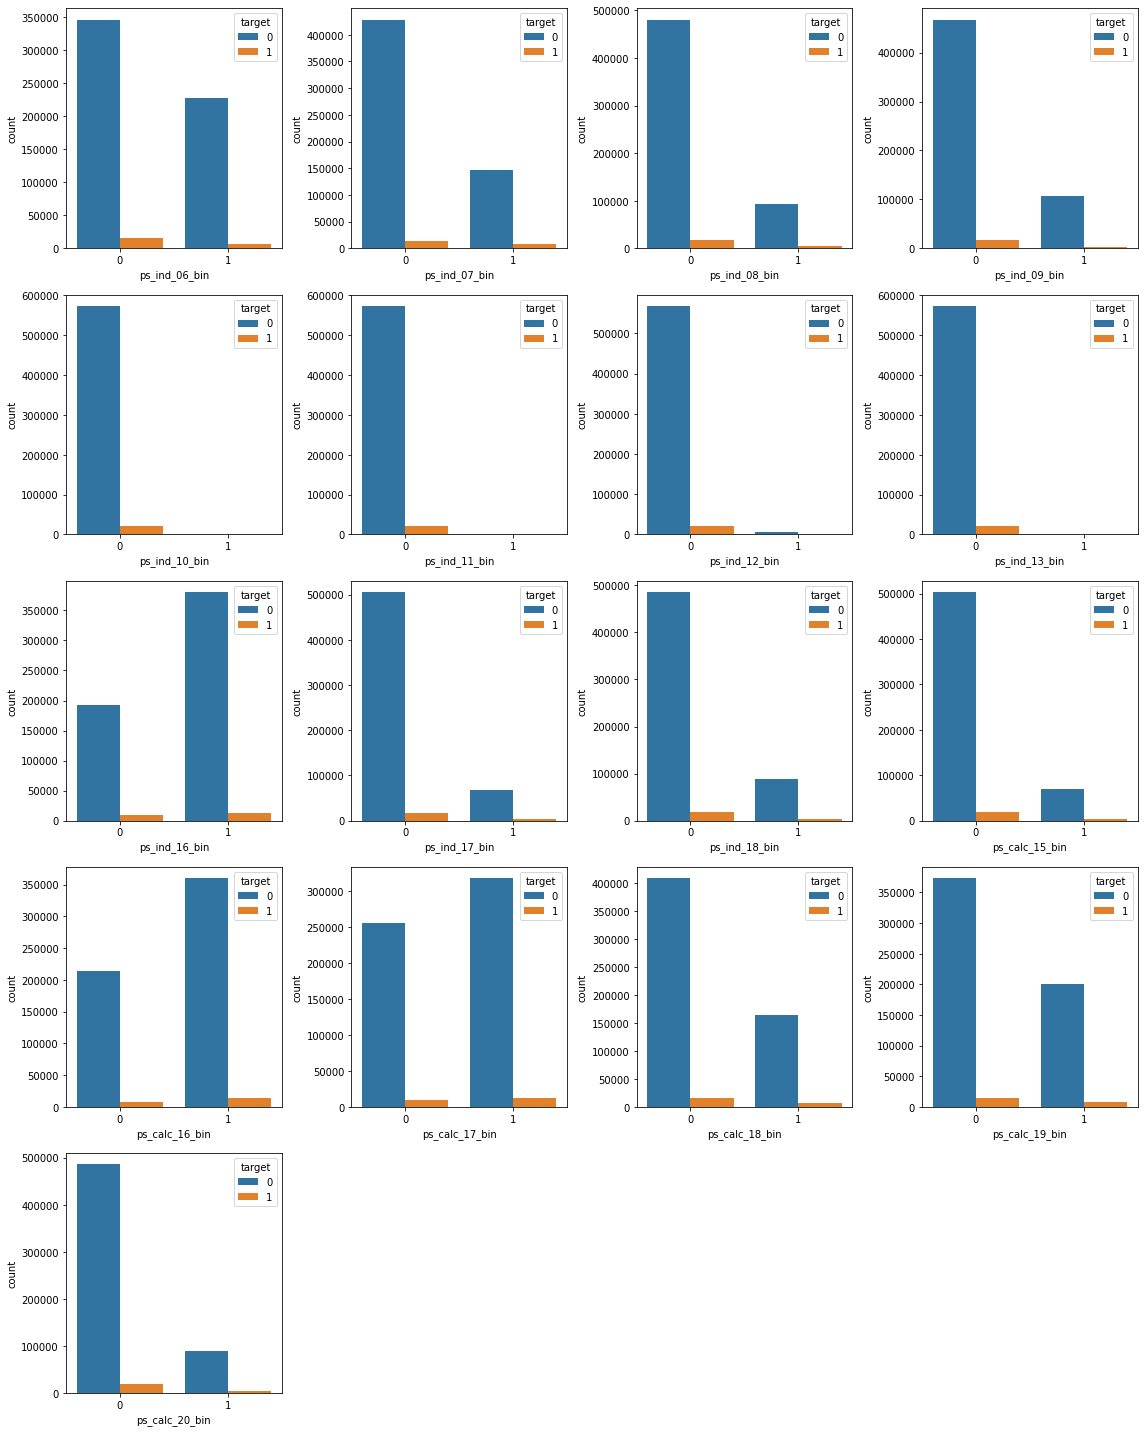

In [ ]:
plt.figure(figsize=(16,20))
plt.title("Count Plots of Binary Features")
for i in range(len(bin_features)):
    plt.subplot(5,4,i+1)
    plt.ylabel('Count')
    sns.countplot(train[bin_features[i]], hue=y)
    plt.tight_layout()

In [ ]:
for i in cat_features:
    cardinality = len(list(train[i].unique()))
    print("Cardinality of '{}' : {}".format(i, cardinality))

Cardinality of 'ps_ind_02_cat' : 5
Cardinality of 'ps_ind_04_cat' : 3
Cardinality of 'ps_ind_05_cat' : 8
Cardinality of 'ps_car_01_cat' : 13
Cardinality of 'ps_car_02_cat' : 3
Cardinality of 'ps_car_03_cat' : 3
Cardinality of 'ps_car_04_cat' : 10
Cardinality of 'ps_car_05_cat' : 3
Cardinality of 'ps_car_06_cat' : 18
Cardinality of 'ps_car_07_cat' : 3
Cardinality of 'ps_car_08_cat' : 2
Cardinality of 'ps_car_09_cat' : 6
Cardinality of 'ps_car_10_cat' : 3
Cardinality of 'ps_car_11_cat' : 104


In [ ]:
missing_values(train[cat_features])

Missing Values in 'ps_ind_02_cat' : 0.0363 %
Missing Values in 'ps_ind_04_cat' : 0.0139 %
Missing Values in 'ps_ind_05_cat' : 0.9760 %
Missing Values in 'ps_car_01_cat' : 0.0180 %
Missing Values in 'ps_car_02_cat' : 0.0008 %
Missing Values in 'ps_car_03_cat' : 69.0898 %
Missing Values in 'ps_car_04_cat' : 0.0000 %
Missing Values in 'ps_car_05_cat' : 44.7825 %
Missing Values in 'ps_car_06_cat' : 0.0000 %
Missing Values in 'ps_car_07_cat' : 1.9302 %
Missing Values in 'ps_car_08_cat' : 0.0000 %
Missing Values in 'ps_car_09_cat' : 0.0956 %
Missing Values in 'ps_car_10_cat' : 0.0000 %
Missing Values in 'ps_car_11_cat' : 0.0000 %


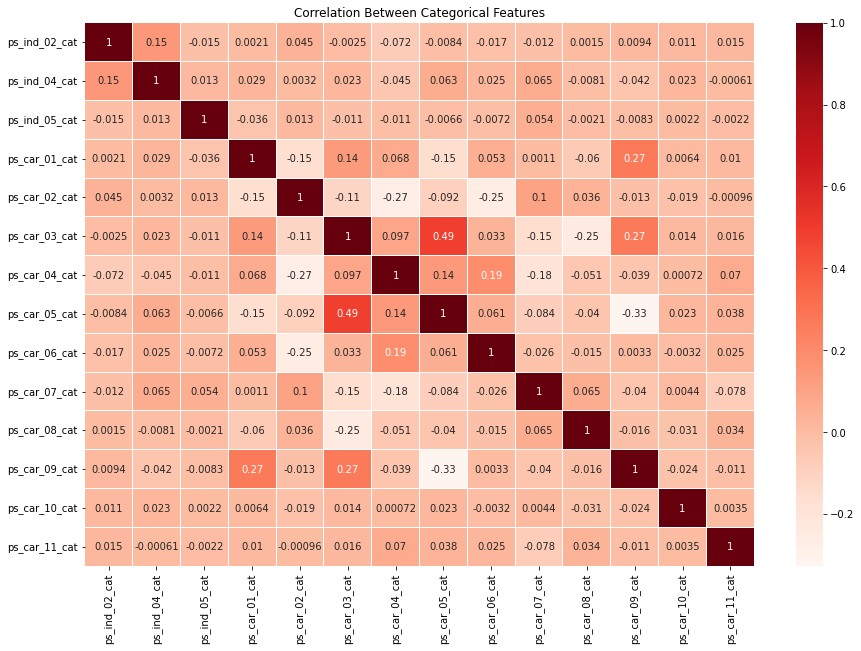

In [ ]:
plt.figure(figsize=(15,10))
plt.title("Correlation Between Categorical Features")
sns.heatmap(train[cat_features].corr(), cmap='Reds', annot = True, linewidths=0.01)

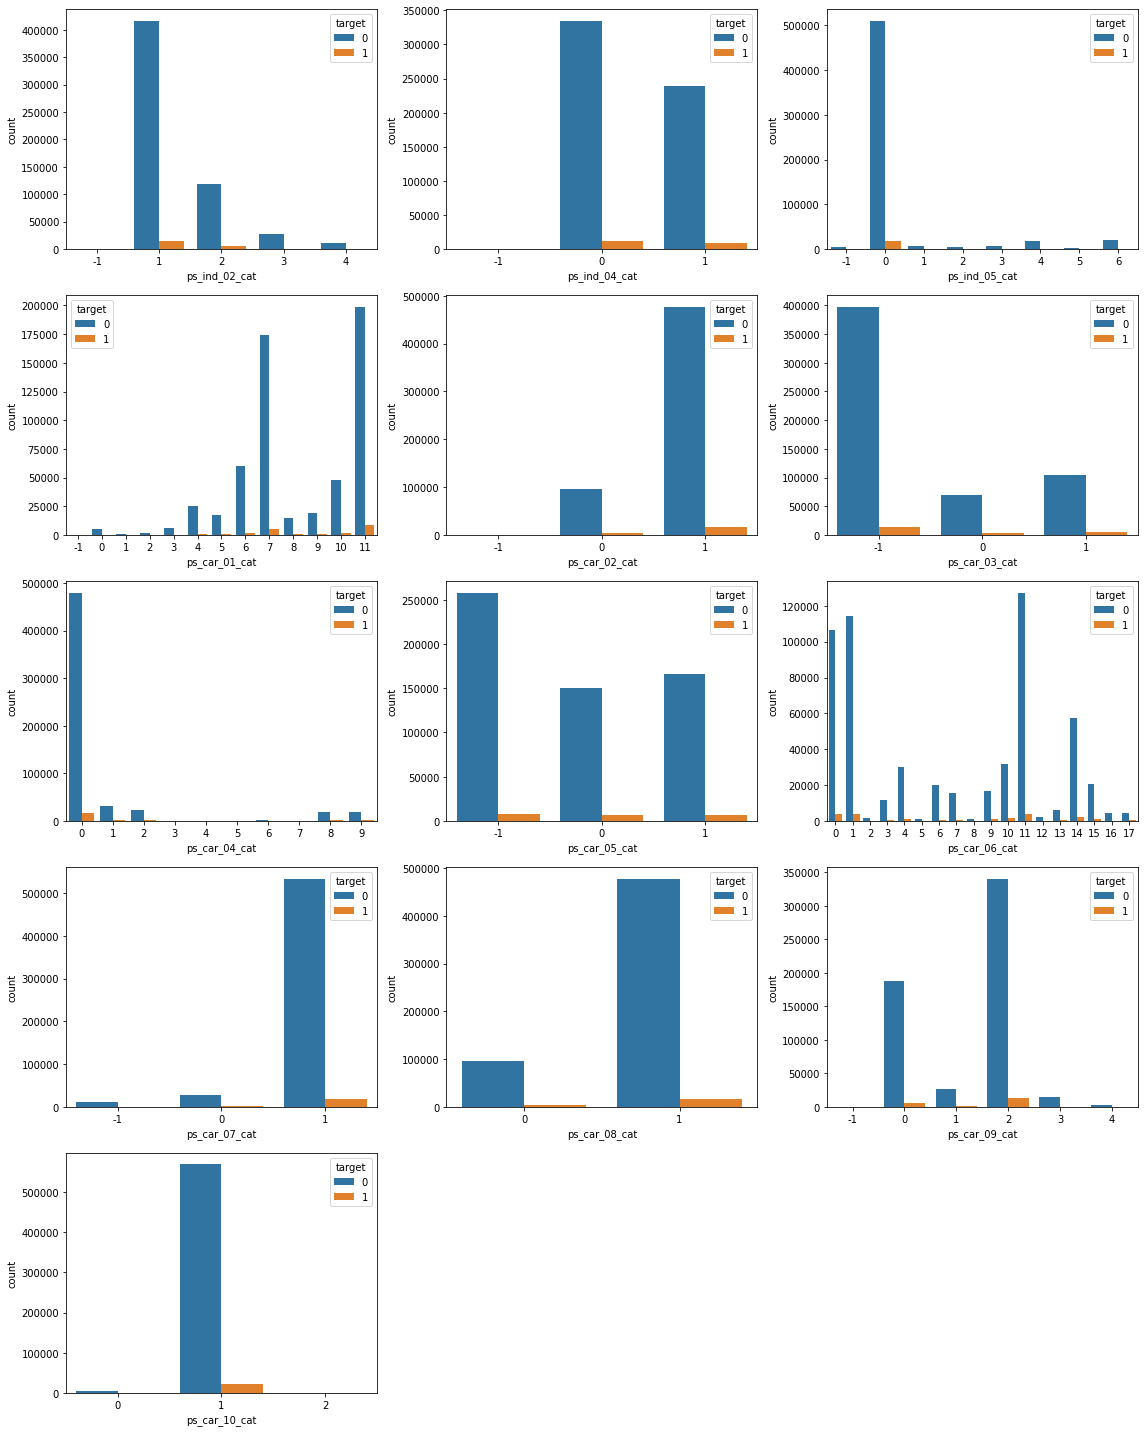

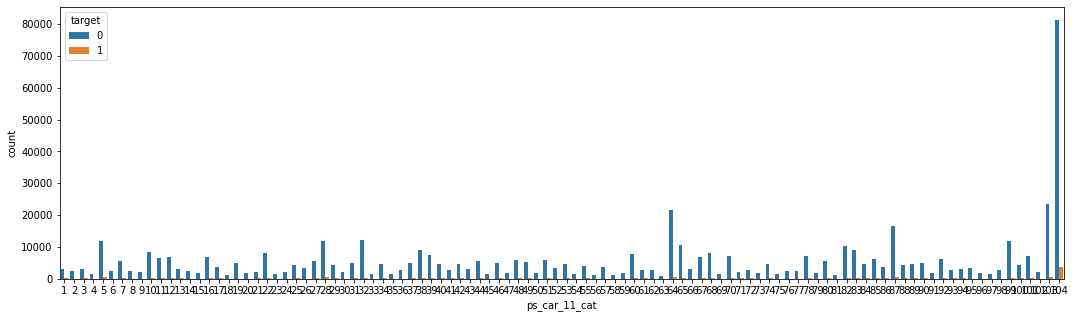

In [ ]:
plt.figure(figsize=(16,20))
plt.title("Count Plots of Categorical Features")
for i in range(len(cat_features)-1):
    plt.subplot(5,3,i+1)
    sns.countplot(train[cat_features[i]], hue=y)
    plt.tight_layout()
plt.figure(figsize=(18,5))
sns.countplot(train['ps_car_11_cat'], hue=y)

In [ ]:
train[num_features_with_calc].describe()

,ps_calc_04,ps_reg_01,ps_car_11,ps_calc_09,ps_car_15,ps_calc_06,ps_reg_03,ps_calc_01,ps_calc_07,ps_calc_02,ps_car_14,ps_calc_12,ps_ind_15,ps_calc_08,ps_ind_14,ps_calc_11,ps_reg_02,ps_ind_01,ps_calc_14,ps_ind_03,ps_calc_03,ps_car_13,ps_calc_13,ps_car_12,ps_calc_05,ps_calc_10
count,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000,595212.000000
mean,2.372081,0.610991,2.346072,2.339034,3.065899,7.689445,0.551102,0.449756,3.005823,0.449589,0.276256,1.441918,7.299922,9.225904,0.012451,5.441382,0.439184,1.900378,7.539026,4.423318,0.449849,0.813265,2.872288,0.379945,1.885886,8.433590
std,1.117219,0.287643,0.832548,1.246949,0.731366,1.334312,0.793506,0.287198,1.414564,0.286893,0.357154,1.202963,3.546042,1.459672,0.127545,2.332871,0.404264,1.983789,2.746652,2.699902,0.287153,0.224588,1.694887,0.058327,1.134927,2.904597
min,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.250619,0.000000,-1.000000,0.000000,0.000000
25%,2.000000,0.400000,2.000000,1.000000,2.828427,7.000000,0.525000,0.200000,2.000000,0.200000,0.333167,1.000000,5.000000,8.000000,0.000000,4.000000,0.200000,0.000000,6.000000,2.000000,0.200000,0.670867,2.000000,0.316228,1.000000,6.000000
50%,2.000000,0.700000,3.000000,2.000000,3.316625,8.000000,0.720677,0.500000,3.000000,0.400000,0.368782,1.000000,7.000000,9.000000,0.000000,5.000000,0.300000,1.000000,7.000000,4.000000,0.500000,0.765811,3.000000,0.374166,2.000000,8.000000
75%,3.000000,0.900000,3.000000,3.000000,3.605551,9.000000,1.000000,0.700000,4.000000,0.700000,0.396485,2.000000,10.000000,10.000000,0.000000,7.000000,0.600000,3.000000,9.000000,6.000000,0.700000,0.906190,4.000000,0.400000,3.000000,10.000000
max,5.000000,0.900000,3.000000,7.000000,3.741657,10.000000,4.037945,0.900000,9.000000,0.900000,0.636396,10.000000,13.000000,12.000000,4.000000,19.000000,1.800000,7.000000,23.000000,11.000000,0.900000,3.720626,13.000000,1.264911,6.000000,25.000000


In [ ]:
missing_values(train[num_features_wo_calc])

Missing Values in 'ps_ind_15' : 0.0000 %
Missing Values in 'ps_ind_01' : 0.0000 %
Missing Values in 'ps_reg_01' : 0.0000 %
Missing Values in 'ps_car_11' : 0.0008 %
Missing Values in 'ps_ind_14' : 0.0000 %
Missing Values in 'ps_ind_03' : 0.0000 %
Missing Values in 'ps_car_15' : 0.0000 %
Missing Values in 'ps_car_13' : 0.0000 %
Missing Values in 'ps_car_12' : 0.0002 %
Missing Values in 'ps_car_14' : 7.1605 %
Missing Values in 'ps_reg_03' : 18.1065 %
Missing Values in 'ps_reg_02' : 0.0000 %


In [ ]:
missing_values(train[calc_num_features])

Missing Values in 'ps_calc_04' : 0.0000 %
Missing Values in 'ps_calc_14' : 0.0000 %
Missing Values in 'ps_calc_08' : 0.0000 %
Missing Values in 'ps_calc_09' : 0.0000 %
Missing Values in 'ps_calc_03' : 0.0000 %
Missing Values in 'ps_calc_06' : 0.0000 %
Missing Values in 'ps_calc_13' : 0.0000 %
Missing Values in 'ps_calc_07' : 0.0000 %
Missing Values in 'ps_calc_02' : 0.0000 %
Missing Values in 'ps_calc_05' : 0.0000 %
Missing Values in 'ps_calc_11' : 0.0000 %
Missing Values in 'ps_calc_12' : 0.0000 %
Missing Values in 'ps_calc_10' : 0.0000 %
Missing Values in 'ps_calc_01' : 0.0000 %


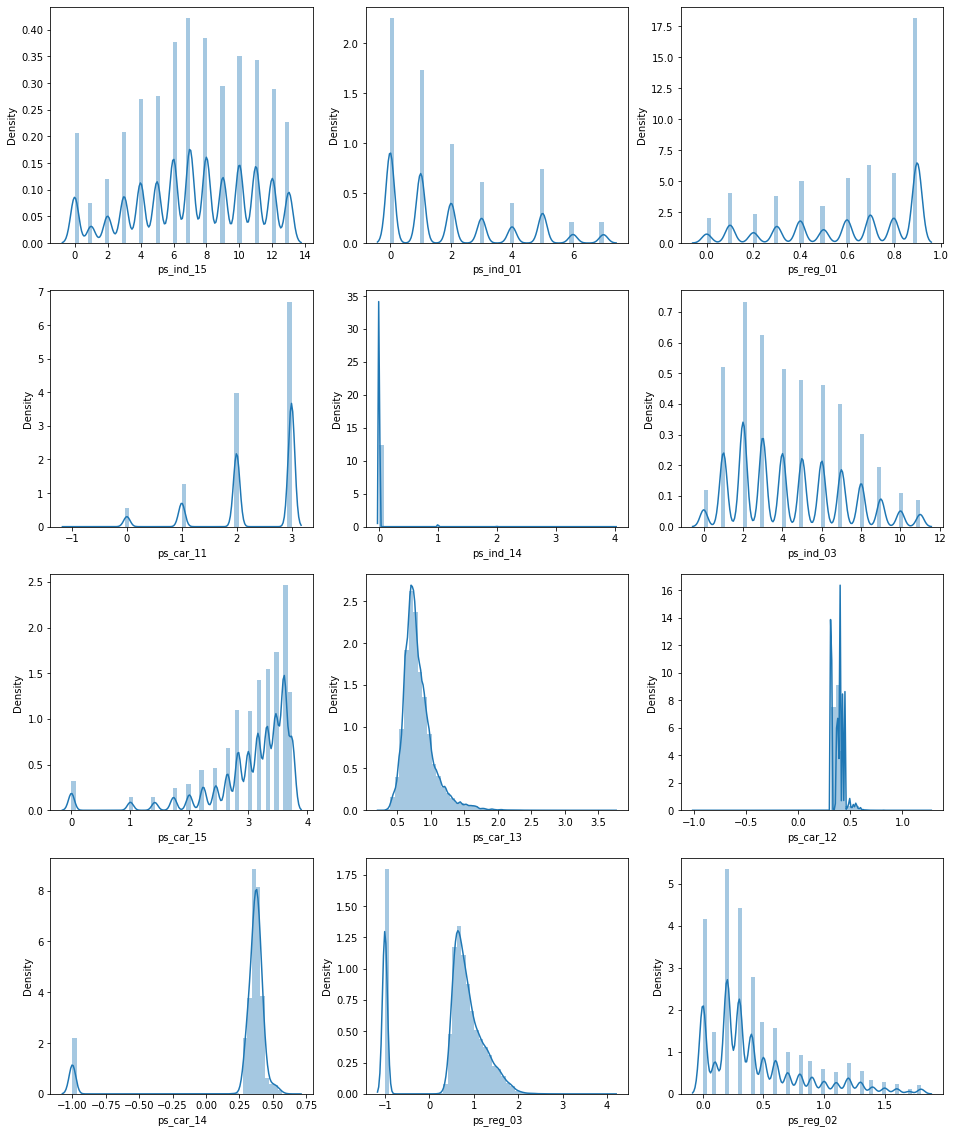

In [ ]:
plt.figure(figsize=(16,20))
for i in range(len(num_features_wo_calc)):
    plt.subplot(4,3,i+1)
    sns.distplot(train[num_features_wo_calc[i]])

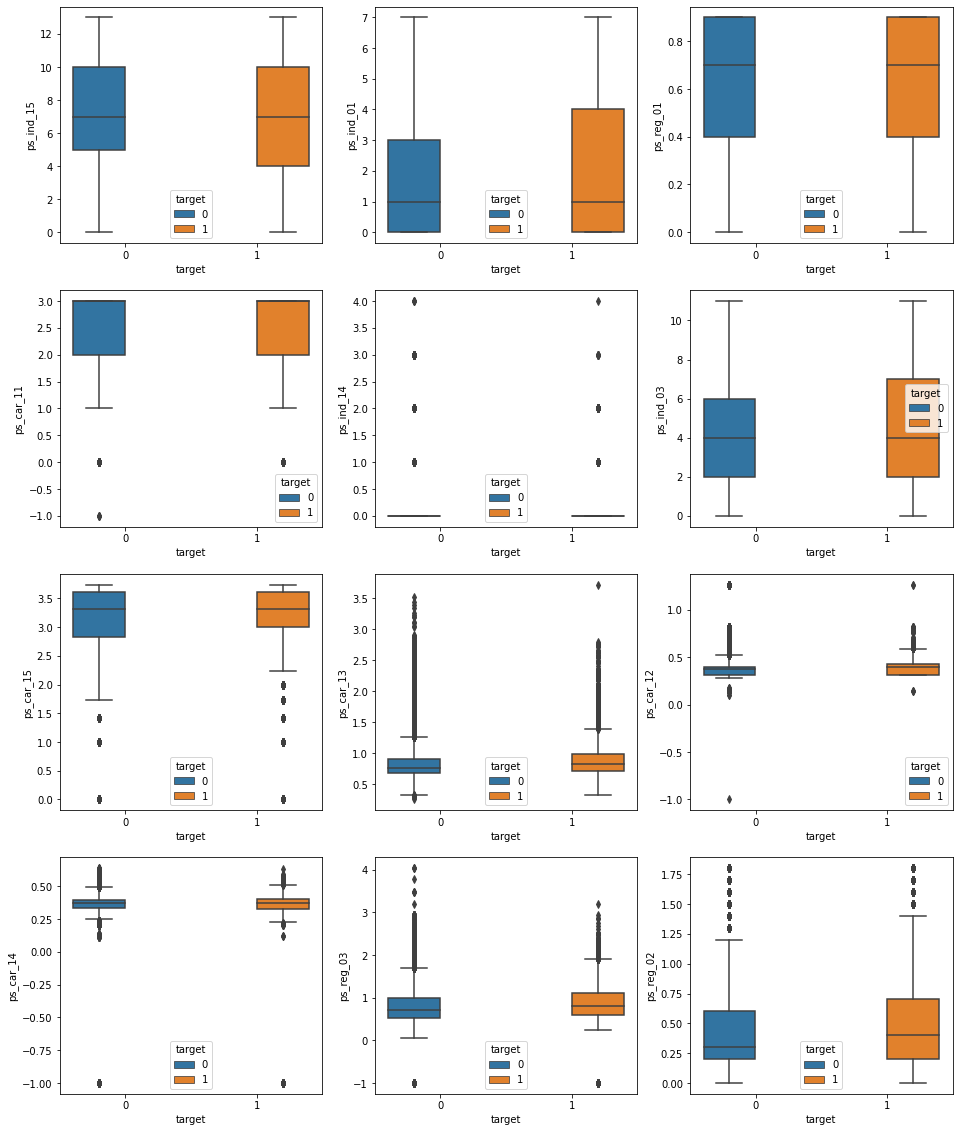

In [ ]:
plt.figure(figsize=(16,20))
for i in range(len(num_features_wo_calc)):
    plt.subplot(4,3,i+1)
    sns.boxplot(y, train[num_features_wo_calc[i]], hue=y)

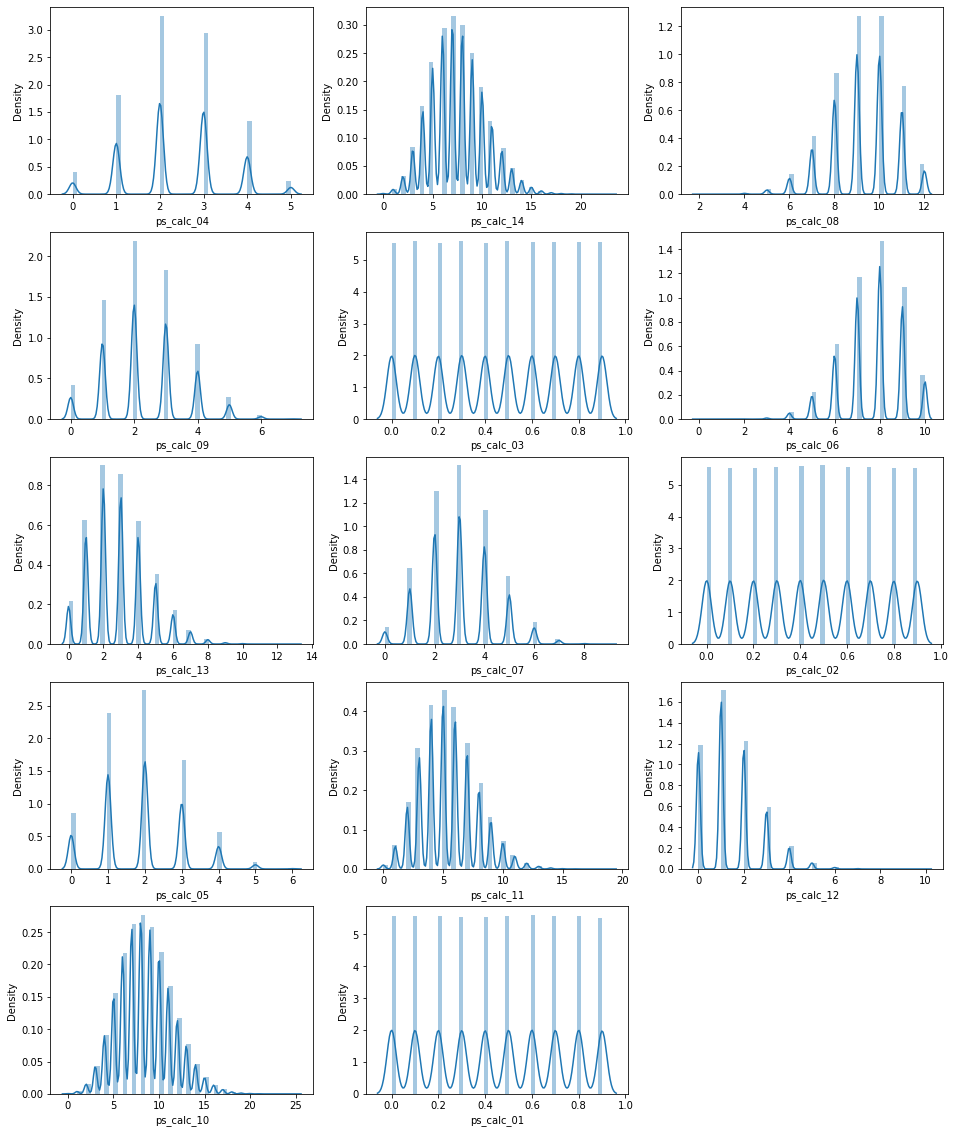

In [ ]:
plt.figure(figsize=(16,20))
for i in range(len(calc_num_features)):
    plt.subplot(5,3,i+1)
    sns.distplot(train[calc_num_features[i]])

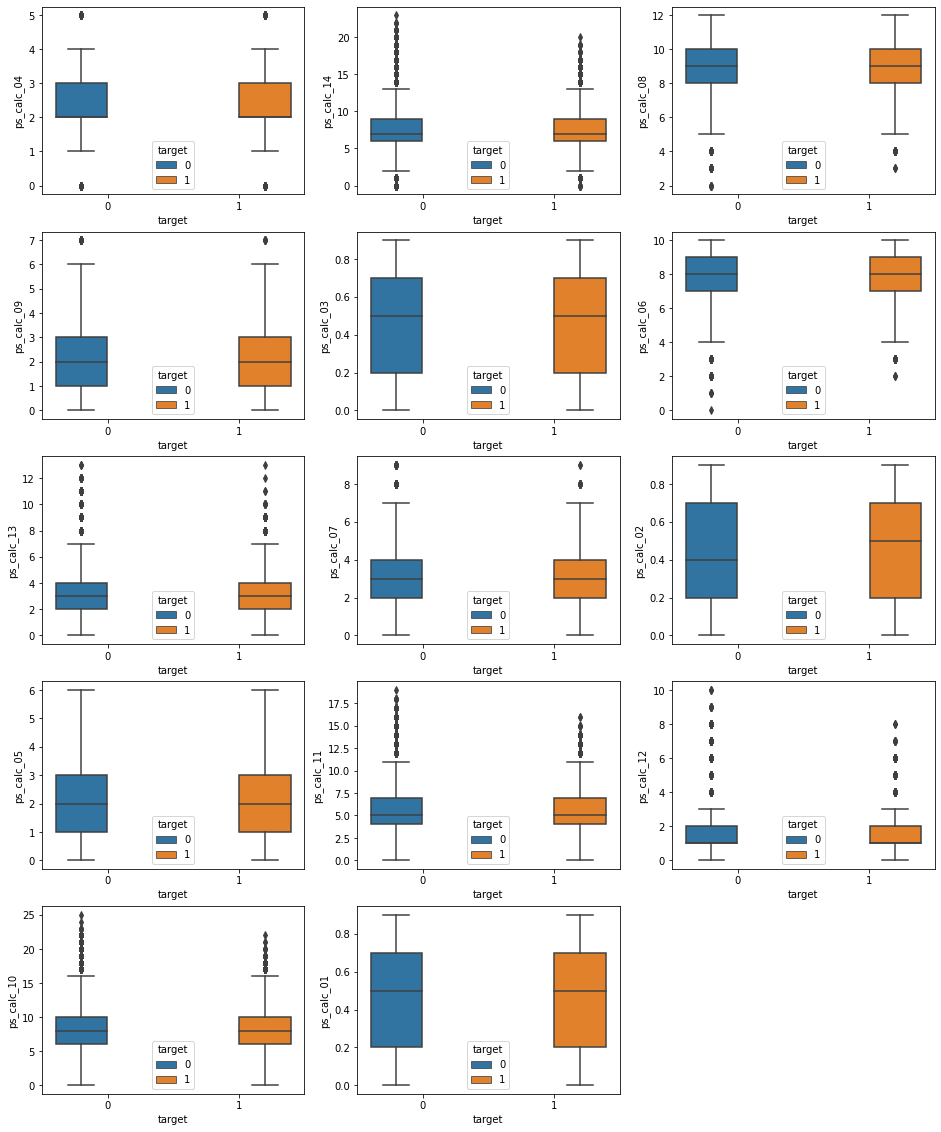

In [ ]:
plt.figure(figsize=(16,20))
for i in range(len(calc_num_features)):
    plt.subplot(5,3,i+1)
    sns.boxplot(y, train[calc_num_features[i]], hue=y)

In [ ]:
train_without_mv = pd.read_csv('train[1].csv')
test_without_mv = pd.read_csv('test[1].csv')

In [ ]:
train_without_mv['missing'] = (train == -1).sum(axis=1)
test_without_mv['missing'] = (test == -1).sum(axis=1)

In [ ]:
print("Shape of New Train without any missing values and with 'missing' :", train_without_mv.shape)
print("Shape of New Test without any missing values and with 'missing' :", test_without_mv.shape)

Shape of New Train without any missing values and with 'missing' : (595212, 60)
Shape of New Test without any missing values and with 'missing' : (892816, 59)


In [ ]:
train_without_mv.drop(calc_features, axis=1, inplace=True)
test_without_mv.drop(calc_features, axis=1, inplace=True)

In [ ]:
print("Final Train Shape :", train_without_mv.shape)
print("Final Test Shape :", test_without_mv.shape)

Final Train Shape : (595212, 40)
Final Test Shape : (892816, 39)


In [ ]:
train_ohe, test_ohe = one_hot_encoding(train_without_mv, test_without_mv, cat_features)

In [ ]:
# dividing the train dataset for cross validation and one_hot_encoding categorical features
# These are for finding the best model
X_train, X_cv, y_train, y_cv = train_test_split(train_without_mv, y, test_size = 0.2, stratify = y, random_state = 2019)
X_train, X_cv = one_hot_encoding(X_train, X_cv, cat_features) 

In [ ]:
scaler = StandardScaler()
scaler.fit(X_train[num_features_wo_calc])

X_train[num_features_wo_calc] = scaler.transform(X_train[num_features_wo_calc])
X_cv[num_features_wo_calc] = scaler.transform(X_cv[num_features_wo_calc])

In [ ]:
print("X_train Shape : ", X_train.shape)
print("X_cv Shape : ", X_cv.shape)

X_train Shape :  (476169, 210)
X_cv Shape :  (119043, 210)


In [ ]:
alpha = [0.0001,0.001,0.01,0.03]
auc_lr1 = {}
gini_lr1 = {}
for i in alpha:
    lr = SGDClassifier(loss='log', alpha=i, n_jobs=-1)
    lr.fit(X_train, y_train)
    
    auc_lr1[i] = roc_auc_score(y_cv, lr.predict_proba(X_cv)[:,1])
    gini_lr1[i] = gini_normalized(y_cv, lr.predict_proba(X_cv)[:,1])

In [ ]:
h = max(gini_lr1, key=auc_lr1.get)
print('Best Gini:', gini_lr1[h])
print('Best AUC:', auc_lr1[h])
print('Best Parameters:', h)

Best Gini: -0.011733201332167788
Best AUC: 0.50001695296138
Best Parameters: 0.001


In [ ]:
auc_lr2 = {}
gini_lr2 = {}
alpha = [0.0001,0.001,0.01,0.03]
for i in alpha:
    lr = SGDClassifier(loss='log', alpha=i, penalty = 'l1', n_jobs=-1)
    lr.fit(X_train, y_train)
    
    auc_lr2[i] = roc_auc_score(y_cv, lr.predict_proba(X_cv)[:,1])
    gini_lr2[i] = gini_normalized(y_cv, lr.predict_proba(X_cv)[:,1])

In [ ]:
h = max(gini_lr2, key=auc_lr2.get)
print('Best Gini:', gini_lr2[h])
print('Best AUC:', auc_lr2[h])
print('Best Parameters:', h)

Best Gini: 1.0
Best AUC: 1.0
Best Parameters: 0.03


In [ ]:
alpha = [0.0001,0.001,0.01,0.03]
auc_svm1 = {}
gini_svm1 = {}
for i in alpha:
    svm = SGDClassifier(alpha=i, n_jobs=-1)
    calib = CalibratedClassifierCV(svm, cv=3)
    calib.fit(X_train, y_train)
    
    auc_svm1[i] = roc_auc_score(y_cv, calib.predict_proba(X_cv)[:,1])
    gini_svm1[i] = gini_normalized(y_cv, calib.predict_proba(X_cv)[:,1])

In [ ]:
h = max(gini_svm1, key=auc_svm1.get)
print('Best Gini:', gini_svm1[h])
print('Best AUC:', auc_svm1[h])
print('Best Parameters:', h)

Best Gini: -0.011904669862440341
Best AUC: 0.5
Best Parameters: 0.0001


In [ ]:
n_est = [1000,1200,1300,1400]
min_samples_leaf = [1000,1100,1200,1300]
auc_rf1 = {}
gini_rf1 = {}
for i in n_est:
    for j in min_samples_leaf:
        rf = RandomForestClassifier(n_estimators=i, min_samples_leaf=j, n_jobs=-1)
        rf.fit(X_train, y_train)
        
        auc_rf1[(i,j)] = roc_auc_score(y_cv, rf.predict_proba(X_cv)[:,1])
        gini_rf1[(i,j)] = gini_normalized(y_cv, rf.predict_proba(X_cv)[:,1])

In [ ]:
h = max(gini_rf1, key=auc_rf1.get)
print('Best Gini:', gini_rf1[h])
print('Best AUC:', auc_rf1[h])
print('Best Parameters:', h)

Best Gini: 1.0
Best AUC: 1.0
Best Parameters: (1000, 1000)


In [ ]:
max_leaf_nodes = [90,100,120,150]
auc_rf2 = {}
gini_rf2 = {}
for i in max_leaf_nodes:
    rf = RandomForestClassifier(n_estimators=1200, min_samples_leaf=1000, max_leaf_nodes=i, n_jobs=-1)
    rf.fit(X_train, y_train)

    auc_rf2[(i,j)] = roc_auc_score(y_cv, rf.predict_proba(X_cv)[:,1])
    gini_rf2[(i,j)] = gini_normalized(y_cv, rf.predict_proba(X_cv)[:,1])

In [ ]:
h = max(gini_rf2, key=auc_rf2.get)
print('Best Gini:', gini_rf2[h])
print('Best AUC:', auc_rf2[h])
print('Best Parameters:', h)

Best Gini: 1.0
Best AUC: 1.0
Best Parameters: (90, 1300)


In [ ]:
n_estimators1 = [700,900,1200,1300]
learning_rate = [0.01,0.1,0.3]
auc_xgb1 = {}
gini_xgb1 = {}
for i in n_estimators1:
    for j in learning_rate:
        xgb_model = xgb.XGBClassifier(n_estimators = i, learning_rate=j, n_jobs=-1)
        xgb_model.fit(X_train, y_train)
        
        auc_xgb1[(i,j)] = roc_auc_score(y_cv, xgb_model.predict_proba(X_cv)[:,1])
        gini_xgb1[(i,j)] = gini_normalized(y_cv, xgb_model.predict_proba(X_cv)[:,1])